<a href="https://colab.research.google.com/github/Esselle7/SINDY-ModelIdentificationFromData/blob/main/Auto_Twin_Pizza_Line_PySINDy_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ambient temperature sensor with a random temperature model. The ambient temperature changes every 10 minutes.

*   Temp(t0) = 20°C
*   Temp(t) = min( max(Temp(t-1) + UNIF(-1°C,+1°C), 18°C) , 25°C)

Sensor to monitor the energy consumption of the refrigerator, which depends on the ambient temperature and the current volume of pizzas in the refrigerator.

Power = 10 kW * (1 – 0.02 * (RoomTemp – 18)) + 5kW * (Actualvolume)/(MAXPIZZAVOLUME*MAXOVENCAPACITY))

Sensor to monitor the energy consumption of the refrigerator, which depends on the ambient temperature and the current volume of pizzas in the refrigerator.

Power = 20 kW * (1 + 0.02 * (RoomTemp – 18)) + 2kW * (Actualvolume)/(MAXPIZZAVOLUME*MAXFREEZERCAPACITY))

Items Source In1 -
Baking P1 -
Freezing P2 -
Packing P3 -
Boxing P4 -
Palletizing P5 -
Storage P6 -
Market P7 -
Box Refurbishing P8 -
Box Warehouse P9

Discard of rejected items Decision Point D1  
Discard of rejected items 2 (Items that cannot be packed together because a new type of item has arrived at the packing station)  
Discard of rejected packages 3 (Packages that cannot be boxed together because a new type of packaging has arrived at the boxing station)  
Discard of unreturned boxes Decision Point D3  
Discard of pallets Decision Point D4

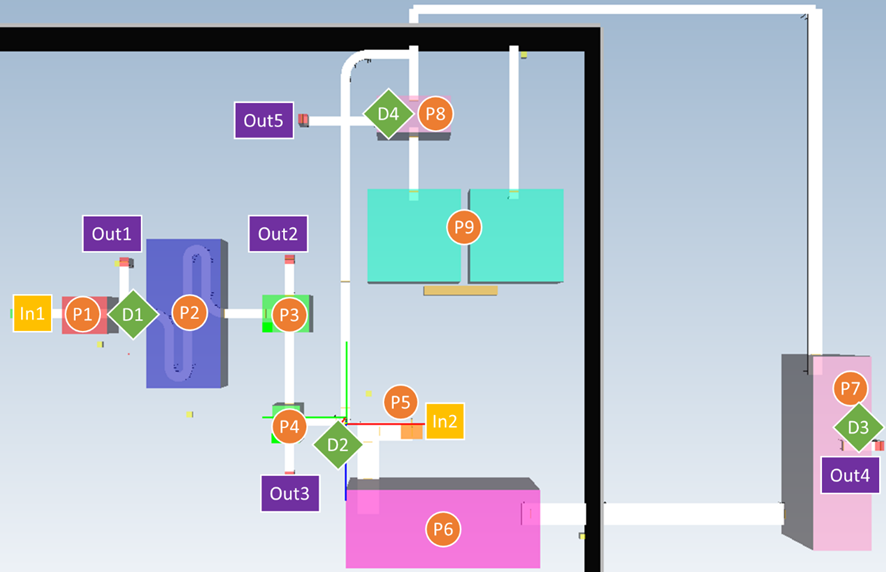

D1
MAX_D = 400 max pizza diameter\
MAX_H = 15 max pizza height\
MAX_VOL = MAX_D^2 * PI  * MAX_H / 4.0\
Vp = volume of the current pizza item\
VR = Vp / MAX_VOL volume ratio with the maximum,  belongs to interval (0,1]\
MAX_P = 10 probability of being defective of the pizza with MAX_VOL\
Then:\
Th = 100 – MAX_P*SQRT(VR)


D2\
Tfreezing > config.robot_max_out_of_refrigerator_time

D3\
ConsumerMarket/exit2Probability

D4\
number of times a box has been refurbished > RefurbishProcess1/refurbishThreshold

#Hoven

In1 --> P1 --> D1 (--> Out1) --> ...

Criterio generazione In1:\
The source loops through the rows of the production plan. It generates for each product code a number of items N=packCount*boxCount*boxQuantity\
The creation interval is extracted from a triangular distribution with:\
modalValue=interval, \
lower=interval-intervalDelta\
upper=interval+intervalDelta\
where interval and intervalDelta are properties of the specific item type defined in production plan.\
The time required to switch production from one item type to another is extracted from a \uniform distribution with mean=15s and standard_dev=3s\
The source skips a creation if there is another item nearer than 500 mm from the point of creation. This causes a block of the generation when the conveyors get filled of items.


Production Plan:

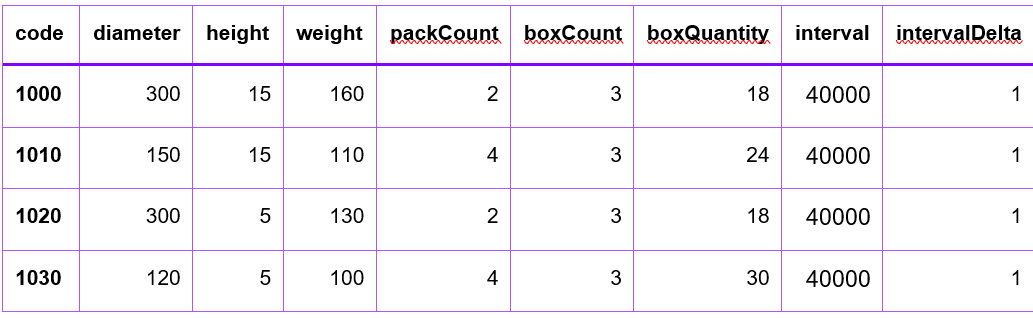

Baking time: the oven works as a pass through with constant speed, the time of persistence inside the oven is then fixed and doesn’t depend on the volume of the pizza.\
The time of persistence increases when:\
•	there is a block of the downstream line (e.g. the freezer blocks) or \
•	there is a breakdown of the oven. \
These two reasons can lead to a baking time higher than expected and then the pizzas are discarded.


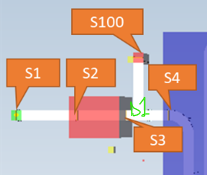

##Import

In [ ]:
!pip install pysindy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data_in = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/CS002.csv',delimiter=';', header=None)
data_out = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/CS003.csv',delimiter=';',header=None)
data_oven = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/Oven1_power.csv',delimiter=';', header=None)
data_oven.columns = ['time', 'sensor', 'val']
data_temp = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/RoomTemperature_signal.csv',delimiter=';', header=None)
data_temp.columns = ['time', 'sensor', 'val']
data_in.columns = ['time', 'sensor', 'id']
data_out.columns = ['time', 'sensor', 'id']

In [ ]:
data_in_test = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/15Days/CS002.csv',delimiter=';', header=None)
data_out_test = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/15Days/CS003.csv',delimiter=';',header=None)
data_oven_test = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/15Days/Oven1_power.csv',delimiter=';', header=None)
data_oven_test.columns = ['time', 'sensor', 'val']
data_temp_test = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/TRAIN_Pizza/15Days/RoomTemperature_signal.csv',delimiter=';', header=None)
data_temp_test.columns = ['time', 'sensor', 'val']
data_in_test.columns = ['time', 'sensor', 'id']
data_out_test.columns = ['time', 'sensor', 'id']

##Manipolazione dati

In [ ]:
import math

def calcVolume(diameter, height):
    raggio = diameter / 2
    volume = math.pi * (raggio ** 2) * height
    return volume
volume1000 = calcVolume(300,15)
volume1010 = calcVolume(150,15)
volume1020 = calcVolume(300,5)
volume1030 = calcVolume(120,5)

In [ ]:
def generateData(di, do, dov, dte):
  data_in_out = pd.concat([di, do]).sort_values('time')
  pieces_count = []
  current_count = 0
  plus = False
  vol = 0
  for index, row in data_in_out.iterrows():
    if "PZ_1000" in row['id']:
      vol = volume1000
    elif "PZ_1010" in row['id']:
      vol = volume1010
    elif "PZ_1020" in row['id']:
      vol = volume1020
    elif "PZ_1030" in row['id']:
      vol = volume1030
    if row['sensor'] == 'CS002':
        current_count += vol
    elif row['sensor'] == 'CS003':
        current_count -= vol
    pieces_count.append(current_count)
  data_in_out = data_in_out.reset_index(drop=True)
  m = 0
  for t in dov['time']:
    if t > data_in_out['time'][0]:
      break
    m = m+1
  data_pizza_volume = []
  j=0
  for i in range(0,len(dov['val']-1)):
    if i < m: #fino a qui non entrano pezzi nel forno
      data_pizza_volume.append(0)
    else:
      if j < len(data_in_out)-1:
        if dov['time'][i] < data_in_out['time'][j+1]:
          data_pizza_volume.append(pieces_count[j])
        else:
          j=j+1
          data_pizza_volume.append(pieces_count[j])
      else:
        data_pizza_volume.append(data_pizza_volume[len(data_pizza_volume)-1])
  data_temp_new = []
  for t in dte['val']:
    for i in range(0,5):
      data_temp_new.append(t)
  data_temp_new.append(25)
  return data_pizza_volume, data_temp_new

In [ ]:
data_pizza_volume , data_temp_new = generateData(data_in, data_out, data_oven, data_temp)

In [ ]:
data_pizza_volume_test , data_temp_new_test = generateData(data_in_test, data_out_test, data_oven_test, data_temp_test)

##Modelli di Identificazione

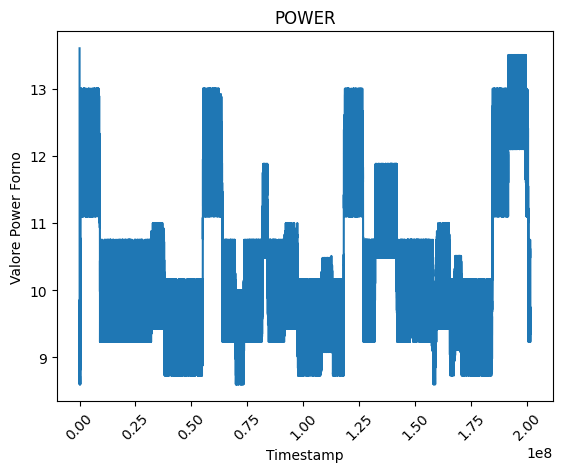

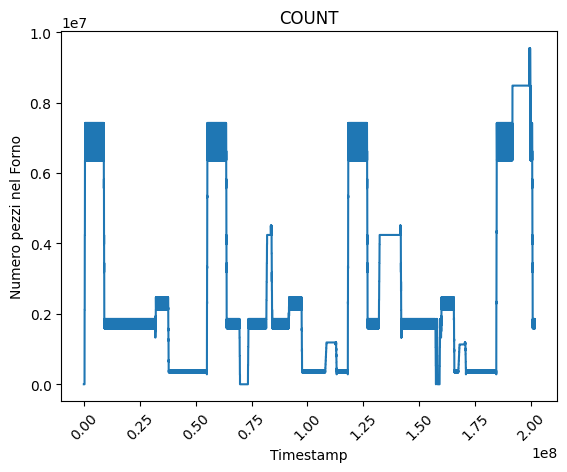

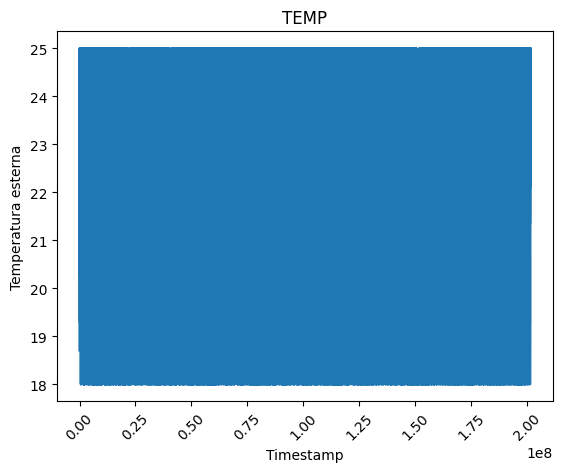

In [ ]:
plt.plot(data_oven['time'], data_oven['val'])
plt.xlabel('Timestamp')
plt.ylabel('Valore Power Forno')
plt.title('POWER')
plt.xticks(rotation=45)
plt.show()
plt.step(data_oven['time'], data_pizza_volume)
plt.xlabel('Timestamp')
plt.ylabel('Numero pezzi nel Forno')
plt.title('COUNT')
plt.xticks(rotation=45)
plt.show()
plt.step(data_oven['time'], data_temp_new)
plt.xlabel('Timestamp')
plt.ylabel('Temperatura esterna')
plt.title('TEMP')
plt.xticks(rotation=45)
plt.show()

###PySindy e Regressore

In [ ]:
init_val = 0
end_val = 100000
print("Dati di train: "+str(end_val-init_val))
print("Dati di test: "+str(len(data_oven['val'])-end_val+init_val))

Dati di train: 100000
Dati di test: 908001


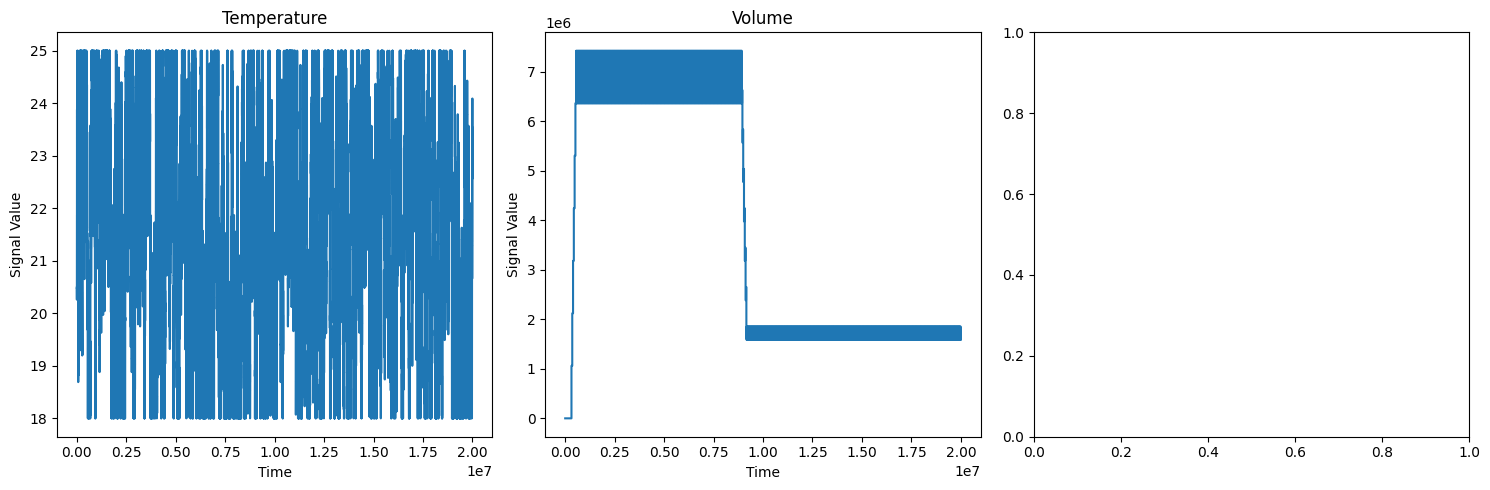

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].step(data_oven['time'][init_val:end_val], data_temp_new[init_val:end_val])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Signal Value')
axs[0].set_title('Temperature')

axs[1].step(data_oven['time'][init_val:end_val], data_pizza_volume[init_val:end_val])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Signal Value')
axs[1].set_title('Volume')

plt.tight_layout()
plt.show()

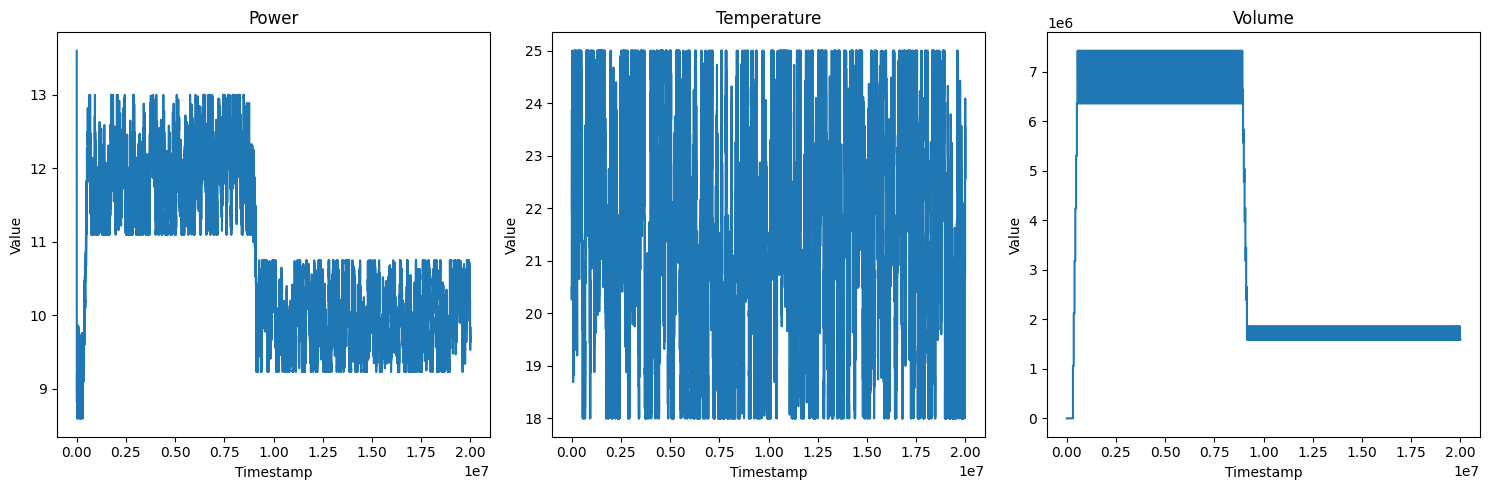

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].step(data_oven['time'][init_val:end_val], data_oven['val'][init_val:end_val])
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Value')
axs[0].set_title('Power')

axs[1].step(data_oven['time'][init_val:end_val], data_temp_new[init_val:end_val])
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Value')
axs[1].set_title('Temperature')

axs[2].step(data_oven['time'][init_val:end_val], data_pizza_volume[init_val:end_val])
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Value')
axs[2].set_title('Volume')

plt.tight_layout()
plt.show()

Mean Squared Error: 0.20010398094971749
R^2 Score: 0.8216555752775405
Intercept: 9.337650411983724
Coefficient: 3.995363579063052e-07


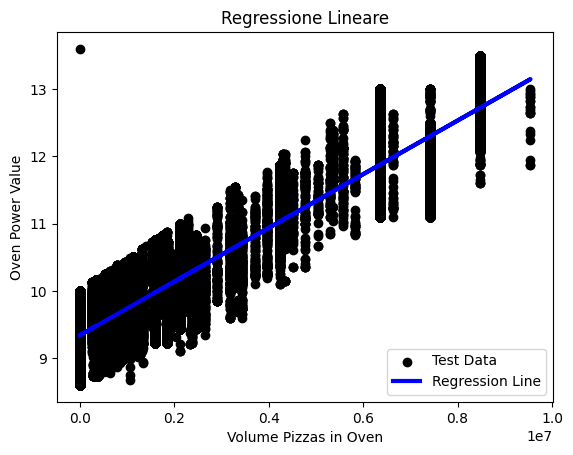

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = np.array(data_pizza_volume).reshape(-1, 1)  # Variabile indipendente (count)
y = np.array(data_oven['val']) # Variabile dipendente (power forno)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

plt.scatter(X_test, y_test, color='black', label='Test Data')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Regression Line')
plt.xlabel('Volume Pizzas in Oven')
plt.ylabel('Oven Power Value')
plt.title('Regressione Lineare')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

X = np.array(data_pizza_volume).reshape(-1, 1)
y = data_oven['val']

model = LinearRegression()
model.fit(X, y)

m = model.coef_[0]  # Coefficiente angolare
q = model.intercept_  # Intercetta

print(f"Coefficiente angolare (m): {m}")
print(f"Intercetta (q): {q}")
offset=m

Coefficiente angolare (m): 3.9939798436070685e-07
Intercetta (q): 9.33814531227099


In [ ]:
import pysindy as ps
model_simple = ps.SINDy(optimizer=ps.STLSQ(threshold=0.01), feature_names = ['P', 'T'], discrete_time=True)
dt=1
model_simple.fit(data_oven['val'][init_val:end_val], u=data_temp_new[init_val:end_val], t=dt)
model_simple.print()

(P)[k+1] = 13.391 1 + 0.032 P[k] + -0.197 T[k] + -0.001 P[k]^2


In [ ]:
model_simple.coefficients()[1:]

array([[0.13697079, 0.        , 0.99361959, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.99994639, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [ ]:
model_simple.coefficients()

array([[ 5.22049032,  0.61702597, -0.0768431 , -3.40502883,  0.        ,
         0.        ,  0.36320011,  0.        ,  0.07147947, -1.42754795],
       [ 0.13697079,  0.        ,  0.99361959,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.99994639,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [ ]:
def sindy_model(interval, initial_value, control_values, coefficients, degree, feature_names):
    values = [initial_value]
    interval_secs = [ts.to_secs() for ts in interval]

    # Define feature names based on control variables
    features = feature_names

    # Generate feature combinations
    feature_combinations = []
    for d in range(1, degree + 1):
        for combo in combinations_with_replacement(features, d):
            feature_combinations.append(combo)

    # Calculate values at each time step
    for i, (t, u) in enumerate(zip(interval_secs[1:], control_values[1:])):
        P_prev = values[-1]

        # Initialize new_value with the constant term
        new_value = coefficients[0, 0]

        # Calculate each term based on the feature combinations
        for j, combo in enumerate(feature_combinations, start=1):
            term_value = 1
            for feature in combo:
                if feature == 'P':
                    term_value *= P_prev
                else:
                    control_index = int(feature[1:])
                    term_value *= u[control_index]
            new_value += coefficients[0, j] * term_value

        values.append(new_value)

    return np.array(values)

In [ ]:
def calculateOvenPower(Pk, Tk):
    a = 13.391
    b = 0.032
    c = -0.197
    d = -0.001
    Pk1 = a + b * Pk + c * Tk + d * Pk**2
    return Pk1

generatedPower = []
prevP = data_oven['val'][0]
for t,v in zip(data_temp_new,data_pizza_volume):
  generatedPower.append(prevP)
  newP = calculateOvenPower(prevP, t)
  prevP = newP+offset*v

Mean Squared Error: 0.00832989276846432


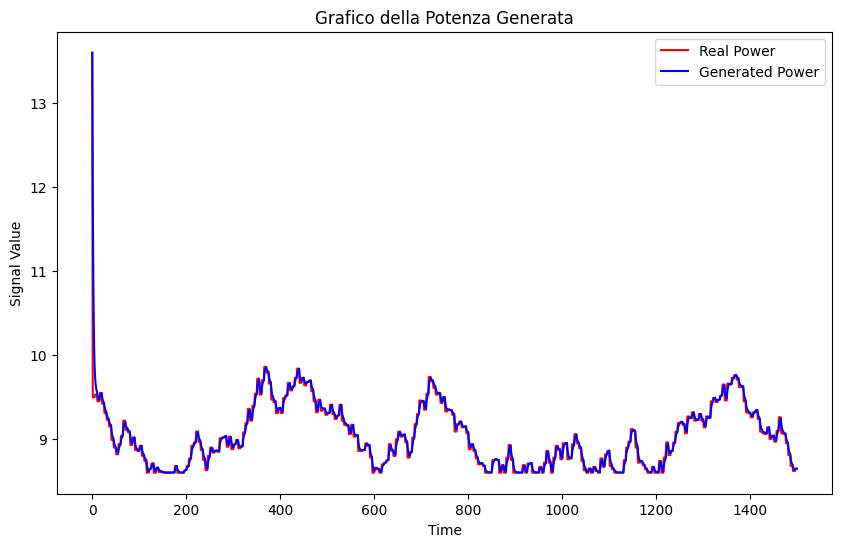

In [ ]:
end_test = 1500
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_oven['val'][:end_test], generatedPower[:end_test])
print(f"Mean Squared Error: {mse}")
plt.figure(figsize=(10, 6))
plt.plot(data_oven['val'][:end_test], color='r', label='Real Power')
plt.plot(generatedPower[:end_test], color='b', label='Generated Power')
plt.title('Grafico della Potenza Generata')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()

In [ ]:
generatedPowerTest = []
prevP = data_oven_test['val'][0]
for t,v in zip(data_temp_new_test,data_pizza_volume_test):
  generatedPowerTest.append(prevP)
  newP = calculateOvenPower(prevP, t)
  prevP = newP+offset*v

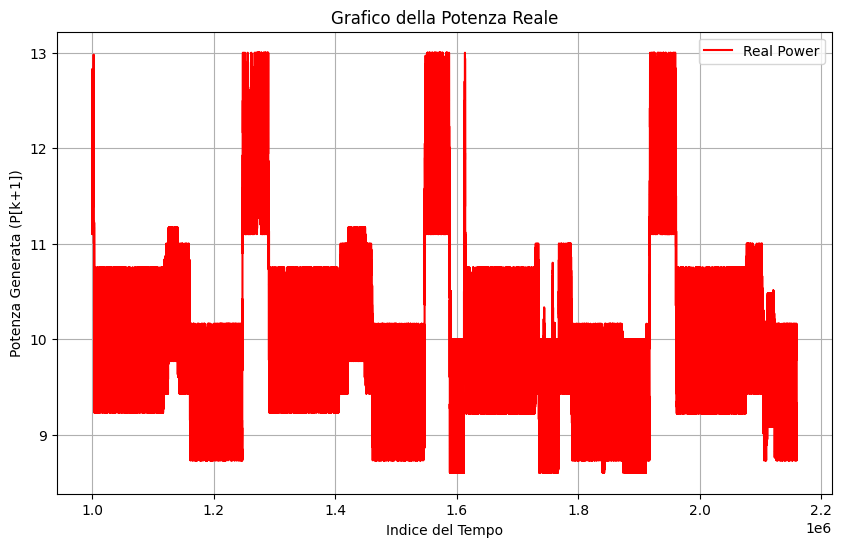

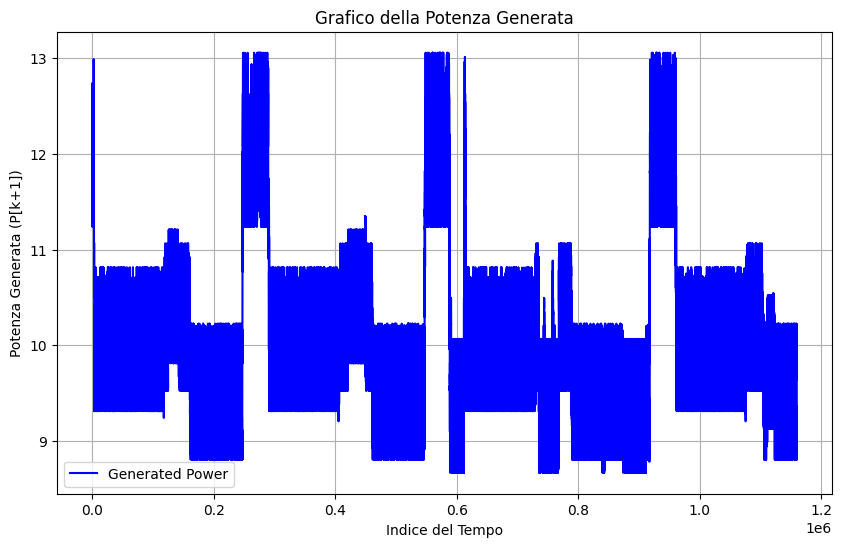

In [ ]:
DaysDelimiter = 1000000
plt.figure(figsize=(10, 6))
plt.plot(data_oven_test['val'][DaysDelimiter:], color='r', label='Real Power')
#plt.plot(generatedPowerTest, color='b', label='Generated Power')
plt.title('Grafico della Potenza Reale')
plt.xlabel('Indice del Tempo')
plt.ylabel('Potenza Generata (P[k+1])')
plt.legend()
plt.grid(False)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(generatedPowerTest[DaysDelimiter:], color='b', label='Generated Power')
plt.title('Grafico della Potenza Generata')
plt.xlabel('Indice del Tempo')
plt.ylabel('Potenza Generata (P[k+1])')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_oven_test['val'], generatedPowerTest)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.011222968294350781


###Modello PySindy new

In [ ]:
init_val = 900000
end_val = 1008001
print("Dati di train: "+str(end_val-init_val))
print("Dati di test: "+str(init_val))

Dati di train: 108001
Dati di test: 900000


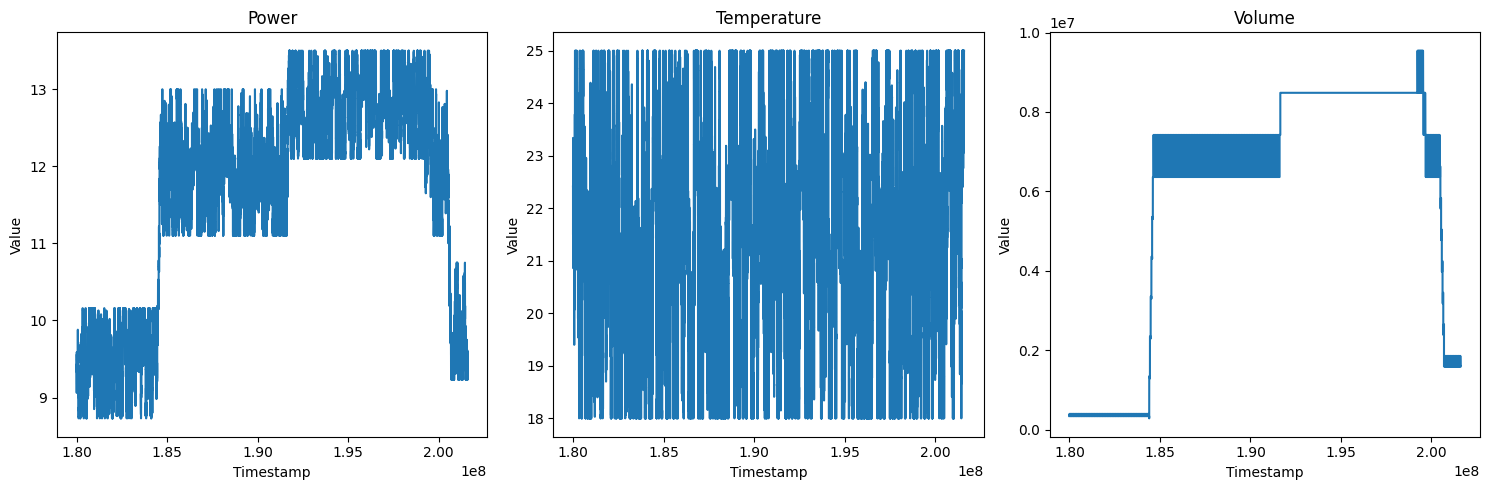

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].step(data_oven['time'][init_val:end_val], data_oven['val'][init_val:end_val])
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Value')
axs[0].set_title('Power')

axs[1].step(data_oven['time'][init_val:end_val], data_temp_new[init_val:end_val])
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Value')
axs[1].set_title('Temperature')

axs[2].step(data_oven['time'][init_val:end_val], data_pizza_volume[init_val:end_val])
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Value')
axs[2].set_title('Volume')

plt.tight_layout()
plt.show()

In [ ]:
# Sclaing degli array dei volumi di pizza
factor = 1e-7
data_pizza_volume_scaled = []
for v in data_pizza_volume:
  scaled = v*factor
  data_pizza_volume_scaled.append(scaled)
data_pizza_volume_scaled_test = []
for v in data_pizza_volume_test:
  scaled = v*factor
  data_pizza_volume_scaled_test.append(scaled)

In [ ]:
model_simple = ps.SINDy(optimizer=ps.STLSQ(threshold=0.01), feature_names = ['P', 'T', 'V'], discrete_time=True)
x_train = np.column_stack((data_oven['val'][init_val:end_val], data_temp_new[init_val:end_val],np.array(data_pizza_volume_scaled)[init_val:end_val]))
dt=1
model_simple.fit(x_train, t=dt)
model_simple.print()

(P)[k+1] = 5.220 1 + 0.617 P[k] + -0.077 T[k] + -3.405 V[k] + 0.363 P[k] V[k] + 0.071 T[k] V[k] + -1.428 V[k]^2
(T)[k+1] = 0.137 1 + 0.994 T[k]
(V)[k+1] = 1.000 V[k]


In [ ]:
model_simple.coefficients().shape[0]

3

In [ ]:
model_simple.feature_names

['P', 'T', 'V']

In [ ]:
model_simple.coefficients()

array([[ 5.22049032,  0.61702597, -0.0768431 , -3.40502883,  0.        ,
         0.        ,  0.36320011,  0.        ,  0.07147947, -1.42754795],
       [ 0.13697079,  0.        ,  0.99361959,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.99994639,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [ ]:
from itertools import combinations_with_replacement
features = ['P', 'T', 'V']
feature_combinations = []
for d in range(1, 2 + 1):
    for combo in combinations_with_replacement(features, d):
        feature_combinations.append(combo)
print(feature_combinations)

[('P',), ('T',), ('V',), ('P', 'P'), ('P', 'T'), ('P', 'V'), ('T', 'T'), ('T', 'V'), ('V', 'V')]


In [ ]:
def calculate_next_P(P, T, V):
    a0 = 5.220
    a1 = 0.617
    a2 = -0.077
    a3 = -3.405
    a4 = 0.363
    a5 = 0.071
    a6 = -1.428
    next_P = (a0 +
              a1 * P +
              a2 * T +
              a3 * V +
              a4 * P * V +
              a5 * T * V +
              a6 * V**2)
    return next_P

generatedPower = []
prevP = data_oven['val'][0]
for t,v in zip(data_temp_new,data_pizza_volume_scaled):
  generatedPower.append(prevP)
  newP = calculate_next_P(prevP, t, v)
  prevP=newP

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_oven['val'], generatedPower)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.017212797917101053


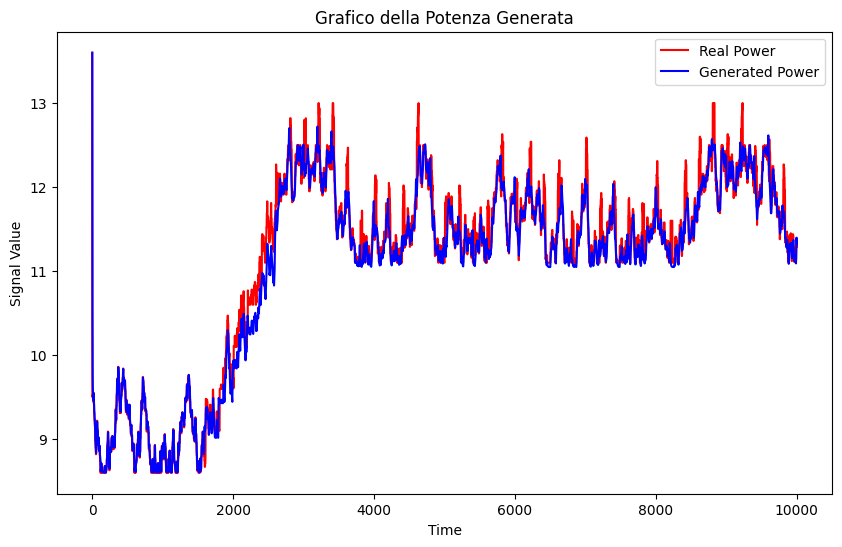

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_oven['val'][:10000], color='r', label='Real Power')
plt.plot(generatedPower[:10000], color='b', label='Generated Power')
plt.title('Grafico della Potenza Generata')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(False)

In [ ]:
generatedPowerTest = []
prevP = data_oven_test['val'][0]
for t,v in zip(data_temp_new_test,data_pizza_volume_scaled_test):
  generatedPowerTest.append(prevP)
  newP = calculate_next_P(prevP, t,v)
  prevP = newP

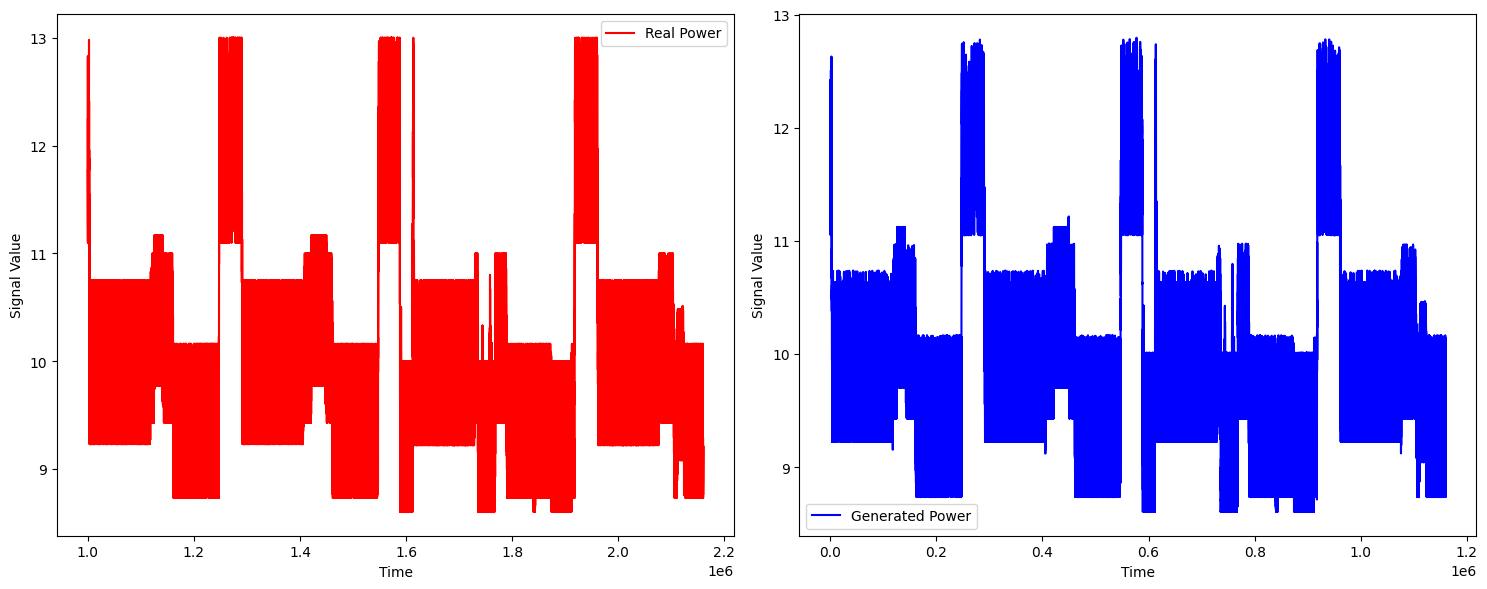

In [ ]:
DaysDelimiter = 1000000

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Grafico della Potenza Reale
axs[0].plot(data_oven_test['val'][DaysDelimiter:], color='r', label='Real Power')
axs[0].set_title('')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Signal Value')
axs[0].legend()
axs[0].grid(False)

# Grafico della Potenza Generata
axs[1].plot(generatedPowerTest[DaysDelimiter:], color='b', label='Generated Power')
axs[1].set_title('')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Signal Value')
axs[1].legend()
axs[1].grid(False)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_oven_test['val'], generatedPowerTest)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.01351621685615062
